# MScFE 642 DEEP LEARNING FOR FINANCE
## Group Work Project # 1
### Student Group 8422
### Yesheng Huang, Atakan Devrent, Mukiza Rayner

In this project, we are aiming to analyze daily prices of the TSLA stock for the last 2000 trading days. Then, we are going to build an **MLP** using the **PyTorch** framework to predict both the prices and log returns of the stock, separately. As our last work, we are going to transform our time series data for **Gramian Angular Field** representation and try to predict the prices and log returns of the stock using **Convolutional Neural Networks**.

## Step 1

In [71]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
from datetime import date, timedelta
import statsmodels
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import torch
import torchinfo

We first download our data and select only the **Close** column for daily close prices. Then, we generate log returns to make the time series stationary.

In [72]:
end_date = date(2025, 2, 10)
start_date = end_date - timedelta(days=2908)
ticker = "TSLA"

data = yf.download(ticker, start_date, end_date)
data = data.droplevel(1, axis=1)

# Generate log returns
data["logr"] = data["Close"].apply(np.log).diff()
data.dropna(inplace=True)

# Drop extra columns
data = data.loc[:, ["Close", "logr"]]

[*********************100%***********************]  1 of 1 completed


### Step 1.a

    Gather information on the time series of the prices (i.e. the levels) of any security of your choice: equity, cryptocurrencies, options, bonds, volatilities... Provide a characterization of the main properties of that time series: summary statistics about its distribution, persistence, stationarity...

First, we print the last few rows of the data to get an idea of what it looks like.

Then, we show the minimum, maximum, mean and different percentiles of the prices time series.

In [73]:
prices = data["Close"]

print(prices.tail(5))
print("-"*50)
print(prices.describe())

Date
2025-02-03    383.679993
2025-02-04    392.209991
2025-02-05    378.170013
2025-02-06    374.320007
2025-02-07    361.619995
Name: Close, dtype: float64
--------------------------------------------------
count    2000.000000
mean      146.515476
std       117.137143
min        11.931333
25%        22.296333
50%       167.845001
75%       238.844170
max       479.859985
Name: Close, dtype: float64


To have a better understanding, we plot the prices against time and then, empirical distribution of prices using a histogram.

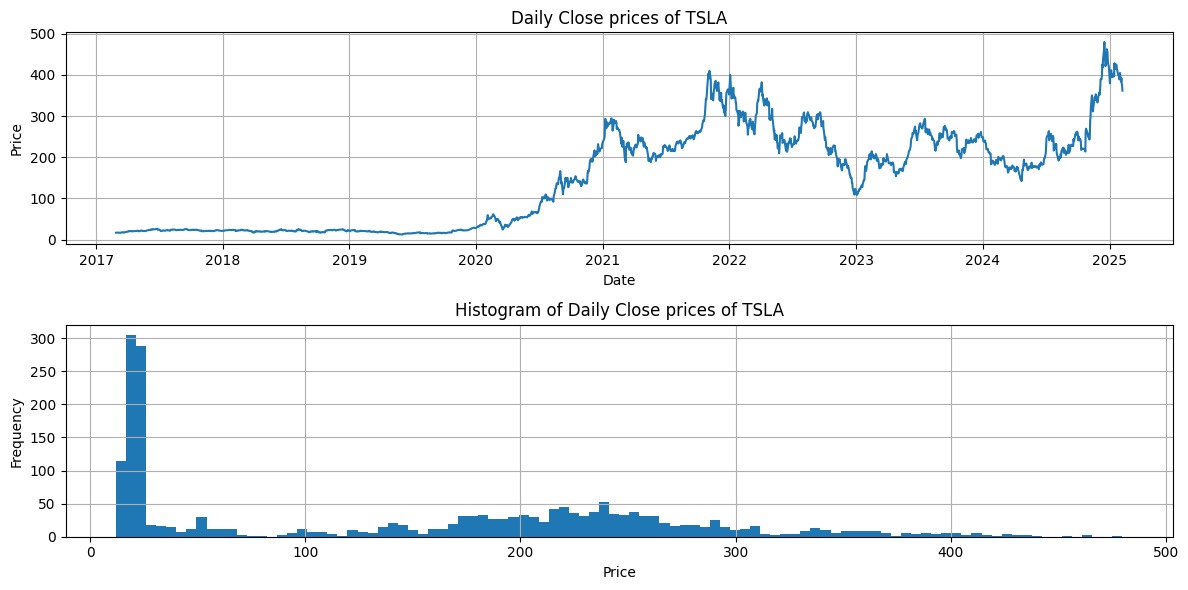

In [74]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(prices)
axs[0].set_title("Daily Close prices of TSLA")
axs[0].set_ylabel("Price")
axs[0].set_xlabel("Date")
axs[0].grid()

axs[1].hist(prices, bins=100)
axs[1].set_title("Histogram of Daily Close prices of TSLA")
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("Price")
axs[1].grid()

fig.tight_layout()

Eye-balling the chart, we can guess that the price of TSLA stock is not stationary. However, to be precise, we apply **Augmented Dickey-Fuller** test to check for stationarity.

In [75]:
adftest = adfuller(prices)
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -1.210106
ADF p-value: 0.669233


According to the result of the ADF test, we cannot reject the null hypothesis of non-stationarity. Therefore we conclude our prices time series is not stationary.

### Step 1.b

    Perform the same analysis for a transformed version of the time series that is stationary (e.g. taking first or second differences, taking logs...). To provide arguments about stationarity, you can, for instance, generate visualizations of the time series and use the Augmented Dickey-Fuller (ADF test).

Just like before, we print the last few rows and print the descriptive statistics of our data, however this time the data is the **log returns**.

In [76]:
log_returns = data["logr"]

print(log_returns.tail(5))
print("-"*50)
print(log_returns.describe())

Date
2025-02-03   -0.053090
2025-02-04    0.021989
2025-02-05   -0.036454
2025-02-06   -0.010233
2025-02-07   -0.034517
Name: logr, dtype: float64
--------------------------------------------------
count    2000.000000
mean        0.001525
std         0.038439
min        -0.236518
25%        -0.018009
50%         0.001467
75%         0.020278
max         0.198187
Name: logr, dtype: float64


.. and plotting

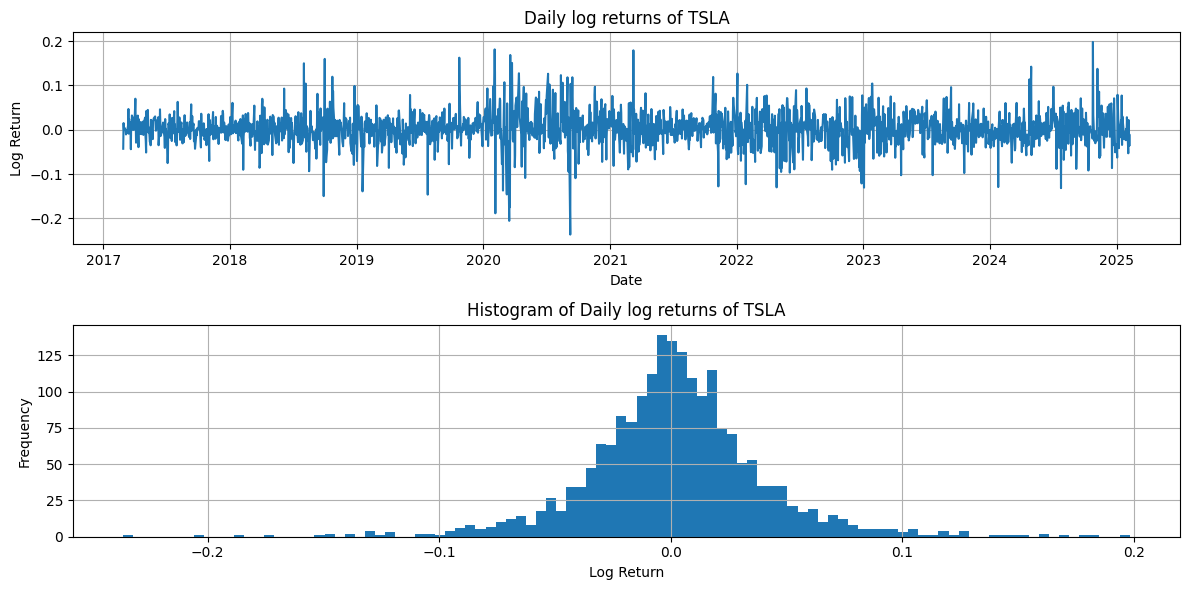

In [77]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(log_returns)
axs[0].set_title("Daily log returns of TSLA")
axs[0].set_ylabel("Log Return")
axs[0].set_xlabel("Date")
axs[0].grid()

axs[1].hist(log_returns, bins=100)
axs[1].set_title("Histogram of Daily log returns of TSLA")
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("Log Return")
axs[1].grid()

fig.tight_layout()

Looking at the graphs, our time series seems stationary. But to be exact, let's apply an ADF test again.

In [78]:
adftest = adfuller(log_returns)
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -30.767141
ADF p-value: 0.000000


With a p-value of $0$, we can confidently reject the null hypothesis and decide that our time series is indeed **stationary**.

Moreover, because we have a stationary distribution and the graph looks like a bell curve, we can also apply a normality test to check if our log returns distribution follows the Gaussian distribution. We are going to use the **Shapiro-Wilk** test:

In [79]:
stat, p_value = stats.shapiro(log_returns)
print("Shapiro-Wilk Test (log returns)")
print(f"Test Statistic: {stat:.4f}, p-value: {p_value:.4g}")

Shapiro-Wilk Test (log returns)
Test Statistic: 0.9525, p-value: 5.541e-25


Because we have a p value of $p \simeq 0$, we reject the null hypothesis of Gaussian distribution with nearly 100% significance and conclude our log returns are <u>not</u> normally distributed.

### Step 1.c

    Use fractional differencing to obtain a new version of the time series that is stationary but retains relevant information about the data. As above, provide a characterization of the main properties of that time series.

Source: https://www.kaggle.com/code/elvisesp/time-series-analysis-using-fractional-differencing/notebook

We use the code from our reference to apply fractional differencing to our **prices** data. Let's use a lag of $30$ to featurize *monthly* past price values. Then, we select the optimal fractional difference parameter $d$ which is maximized with the constraint that our fractional time series is **stationary**.

In [80]:
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w

def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients
    
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:]

def optimize_d(series, lags, p_value=0.05):
    # optimize the order of differencing for a given range of lags
    best_d = 0
    best_adf_p = np.inf
    for d in np.linspace(0, 1, 21):
        diff_series = ts_differencing(series, d, lags)
        adf_p = adfuller(diff_series)[1]
        if adf_p < p_value:
            best_adf_p = adf_p
            best_d = d
            print(f"Found d: {best_d}, ADF p-value: {best_adf_p}")
            return best_d

optimum_d = optimize_d(prices, 10)

Found d: 0.8, ADF p-value: 0.007121051969982301


After we have found the optimum $d$ parameter, we create the fractional time series and describe its properties and distribution:

In [81]:
frac_prices = ts_differencing(prices, optimum_d, 10)

print(frac_prices.tail(5))
print("-"*50)
print(frac_prices.describe())

Date
2025-02-03    -4.999084
2025-02-04    19.864458
2025-02-05     0.524402
2025-02-06     7.820703
2025-02-07    -0.635051
Name: Close, dtype: float64
--------------------------------------------------
count    1990.000000
mean        5.714382
std         8.500676
min       -34.418103
25%         0.674661
50%         2.380000
75%         9.997367
max        60.213556
Name: Close, dtype: float64


Then we plot the series as usual:

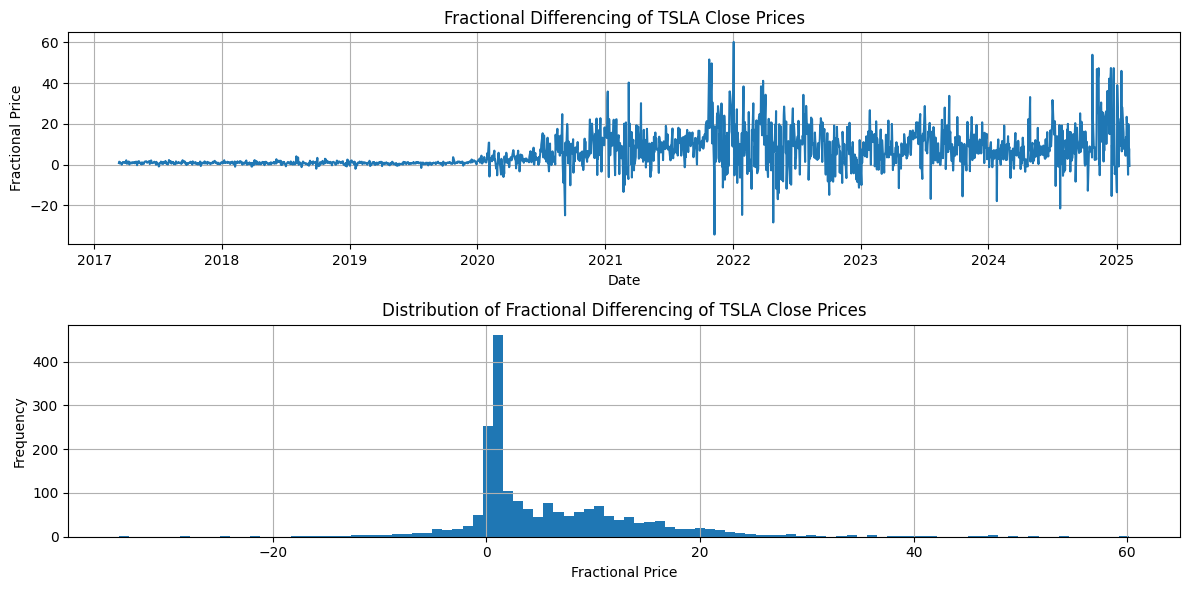

In [82]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(frac_prices)
axs[0].set_title("Fractional Differencing of TSLA Close Prices")
axs[0].set_ylabel("Fractional Price")
axs[0].set_xlabel("Date")
axs[0].grid()

axs[1].hist(frac_prices, bins=100)
axs[1].set_title("Distribution of Fractional Differencing of TSLA Close Prices")
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("Fractional Price")
axs[1].grid()

fig.tight_layout()

And the ADF test as usual:

In [83]:
adftest = adfuller(frac_prices)
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -3.535491
ADF p-value: 0.007121


Although by looking at the plotting we can probably guess that this series is not normally distributed, let's apply a normality test for good measure.

In [84]:
stat, p_value = stats.shapiro(frac_prices)
print("Shapiro-Wilk Test (log returns)")
print(f"Test Statistic: {stat:.4f}, p-value: {p_value:.4g}")

Shapiro-Wilk Test (log returns)
Test Statistic: 0.8640, p-value: 1.821e-38


As expected, our fractional prices time series is not normally distributed according to the Shapiro-Wilk test.

____________

## Step 2

In *Step 2*, we are going to develop a Multi-Layer Perceptron (MLP) to predict our time series that we got in Step 1: **prices** and **log returns**.